# **Read and Preprocess gold_prices.csv**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Start Spark session
spark = SparkSession.builder.appName("GoldPricePrediction").getOrCreate()

# Load CSV from Google Drive or local
csv_path = "/content/drive/MyDrive/MMDS/Final/gold_prices.csv"

# Read CSV with headers and infer schema
df = spark.read.option("header", True).option("inferSchema", True).csv(csv_path)

In [2]:
# Show schema and preview
df.printSchema()
df.show(10)

root
 |-- Date: date (nullable = true)
 |-- Buy Price: double (nullable = true)
 |-- Sell Price: double (nullable = true)

+----------+---------+----------+
|      Date|Buy Price|Sell Price|
+----------+---------+----------+
|2009-08-01|    21.13|     21.19|
|2009-08-02|    21.13|     21.19|
|2009-08-03|    21.13|     21.19|
|2009-08-04|    21.13|     21.19|
|2009-08-05|    21.13|     21.19|
|2009-08-06|    21.13|     21.19|
|2009-08-07|    21.13|     21.19|
|2009-08-08|    21.13|     21.19|
|2009-08-09|    21.13|     21.19|
|2009-08-10|    21.13|     21.19|
+----------+---------+----------+
only showing top 10 rows



In [3]:
df = df.withColumn("Date", col("Date").cast("date"))
df = df.withColumn("Buy Price", col("Buy Price").cast("double"))
df = df.withColumn("Sell Price", col("Sell Price").cast("double"))

# Sort by date (important for lag features)
df = df.orderBy("Date")

# Optional check
print("Total rows:", df.count())

Total rows: 5565


# **1. Introduction**
Objective: Reduce the 10-dimensional feature vectors generated in Task 2 to 5 dimensions using CUR decomposition.

Goal: Improve model efficiency or generalization by reducing input dimensionality, while maintaining comparable predictive performance.

# **2. Reuse Samples from Task 2**
Use the feature-label dataset already created in Task 2:

Features: Buy prices of the previous 10 days.

Label: Buy price on the current day.

Use the same 70/30 train/test split for fair comparison.

In [4]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag
from pyspark.ml.feature import VectorAssembler

# 1. Create lag features for the previous 10 days
windowSpec = Window.orderBy("Date")

for i in range(1, 11):
    df = df.withColumn(f"lag_{i}", lag("Buy Price", i).over(windowSpec))

# 2. Drop any rows with null values introduced by lag
df = df.na.drop()

# 3. Create feature columns list
feature_cols = [f"lag_{i}" for i in range(10, 0, -1)]  # From lag_10 to lag_1

# 4. Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# 5. Final dataset with label and features
data = df.select("features", col("Buy Price").alias("label"))

# 6. Split into training and test sets (70/30)
train_df, test_df = data.randomSplit([0.7, 0.3], seed=42)

# 7. Preview
train_df.show(10, truncate=False)

+-------------------------------------------------------------+-----+
|features                                                     |label|
+-------------------------------------------------------------+-----+
|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|22.09|
+-------------------------------------------------------------+-----+
only showing top 10 

# **3. Apply CUR Decomposition to Reduce Dimensionality**
**3.1 Convert Training and Test Features to RowMatrix**

Convert both training and test sets into PySpark RowMatrix format to enable distributed matrix operations.

**3.2 Compute SVD on Training Data**

Perform truncated Singular Value Decomposition (SVD) on the training matrix to obtain U, S, and Vᵗ.

**3.3 Select Columns and Rows Using Leverage Scores**

Compute leverage scores:

From Vᵗ → select 5 informative columns.

From U → select 5 representative rows.

Select indices based on sampling from these scores.

**3.4 Construct CUR Decomposition**

Extract submatrices:

C: columns from original matrix.

R: rows from original matrix.

W: intersection matrix of selected rows and columns.

Compute pseudo-inverse of W.

Use CUR formula to reconstruct approximate matrix: A ≈ C × W⁺ × R

**3.5 Generate 5D Embeddings**

Use the CUR approximation to project the original data into a new 5-dimensional representation (row embeddings).

Apply this process to both training and test sets.

In [5]:
# 3.1 – Convert Training and Test Features to RowMatrix
from pyspark.mllib.linalg.distributed import RowMatrix

train_rdd = train_df.select("features").rdd.map(lambda row: row.features.toArray())
test_rdd = test_df.select("features").rdd.map(lambda row: row.features.toArray())

train_matrix = RowMatrix(train_rdd)
test_matrix = RowMatrix(test_rdd)

print("Training matrix shape:", train_matrix.numRows(), "x", train_matrix.numCols())

Training matrix shape: 3964 x 10


In [6]:
# 3.2 – Compute Truncated SVD on Training Data
k = 5
num_cols = train_matrix.numCols()
num_rows = train_matrix.numRows()

# Ensure k is safe
k = min(k, num_cols, num_rows - 1)

svd = train_matrix.computeSVD(k, computeU=True)
U = svd.U  # RowMatrix
S = svd.s  # Vector
V = svd.V  # Local Matrix (k x numCols)

print("SVD done. V shape:", V.numRows, "x", V.numCols)

SVD done. V shape: 10 x 5


In [7]:
# 3.3 – Select Columns and Rows Using Leverage Scores
import numpy as np

# Column leverage scores from Vᵗ
V_array = V.toArray()  # shape: k x numCols
V_T = V_array.T        # shape: numCols x k
col_scores = np.sum(V_T ** 2, axis=1)
col_probs = col_scores / np.sum(col_scores)
col_indices = np.random.choice(len(col_probs), size=k, replace=False, p=col_probs)
col_indices.sort()

# Row leverage scores from U
U_array = np.array(U.rows.map(lambda v: np.array(v)).collect())  # small U matrix, safe to collect
row_scores = np.sum(U_array ** 2, axis=1)
row_probs = row_scores / np.sum(row_scores)
row_indices = np.random.choice(len(row_probs), size=k, replace=False, p=row_probs)
row_indices.sort()

In [8]:
# 3.4 – Construct CUR Decomposition
# Full training matrix as local array (only once)
A_train = np.array(train_matrix.rows.map(lambda v: np.array(v)).collect())

# Extract C (all rows, selected columns), R (selected rows, all columns), W (intersection)
C = A_train[:, col_indices]           # shape: n x k
R = A_train[row_indices, :]           # shape: k x d
W = A_train[np.ix_(row_indices, col_indices)]  # shape: k x k

# Compute pseudo-inverse of W
W_pinv = np.linalg.pinv(W)

In [9]:
# 3.5 – Generate CUR Embeddings for Train and Test Sets
# CUR projection: A' = C × W⁺ × R
CUR_train = np.dot(np.dot(C, W_pinv), R)  # shape: n x d
CUR_train_reduced = CUR_train[:, :k]      # shape: n x 5

In [10]:
# Apply same column indices and projection logic to test matrix
A_test = np.array(test_matrix.rows.map(lambda v: np.array(v)).collect())
C_test = A_test[:, col_indices]
CUR_test = np.dot(np.dot(C_test, W_pinv), R)
CUR_test_reduced = CUR_test[:, :k]        # shape: n x 5

# **4. Train and Evaluate a New Linear Regression Model**
Use the CUR-reduced training set to train a PySpark linear regression model.

Predict on both CUR training and test sets.

In [11]:
# 4.1 Convert CUR Embeddings to PySpark DataFrames
from pyspark.ml.linalg import Vectors as MLVectors

# Extract labels from original DataFrames
train_labels = [float(row["label"]) for row in train_df.select("label").collect()]
test_labels = [float(row["label"]) for row in test_df.select("label").collect()]

# Pair features and labels for training set
train_data = [(MLVectors.dense(vec), label) for vec, label in zip(CUR_train_reduced, train_labels)]
test_data = [(MLVectors.dense(vec), label) for vec, label in zip(CUR_test_reduced, test_labels)]

# Create Spark DataFrames
train_df_cur = spark.createDataFrame(train_data, ["features", "label"])
test_df_cur = spark.createDataFrame(test_data, ["features", "label"])

train_df_cur.show(5, truncate=False)

+-----------------------------------------------------------------------------------------------+-----+
|features                                                                                       |label|
+-----------------------------------------------------------------------------------------------+-----+
|[21.129999999999573,21.129999999999615,21.129999999999654,21.129999999999686,21.12999999999973]|21.13|
|[21.129999999999573,21.129999999999615,21.129999999999654,21.129999999999686,21.12999999999973]|21.13|
|[21.129999999999573,21.129999999999615,21.129999999999654,21.129999999999686,21.12999999999973]|21.13|
|[21.129999999999573,21.129999999999615,21.129999999999654,21.129999999999686,21.12999999999973]|21.13|
|[21.129999999999573,21.129999999999615,21.129999999999654,21.129999999999686,21.12999999999973]|21.13|
+-----------------------------------------------------------------------------------------------+-----+
only showing top 5 rows



In [12]:
# 4.2 Train PySpark Linear Regression Model on CUR-Reduced Data
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model_cur = lr.fit(train_df_cur)

# Predict on train and test sets
train_pred_cur = lr_model_cur.transform(train_df_cur)
test_pred_cur = lr_model_cur.transform(test_df_cur)

In [13]:
# 4.3 Evaluate with MSE, RMSE, MAE
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")

# Train set metrics
rmse_train_cur = evaluator_rmse.evaluate(train_pred_cur)
mse_train_cur = evaluator_mse.evaluate(train_pred_cur)
mae_train_cur = evaluator_mae.evaluate(train_pred_cur)

# Test set metrics
rmse_test_cur = evaluator_rmse.evaluate(test_pred_cur)
mse_test_cur = evaluator_mse.evaluate(test_pred_cur)
mae_test_cur = evaluator_mae.evaluate(test_pred_cur)

print("=== CUR Regression Metrics ===")
print(f"Train RMSE: {rmse_train_cur:.4f}, MSE: {mse_train_cur:.4f}, MAE: {mae_train_cur:.4f}")
print(f"Test  RMSE: {rmse_test_cur:.4f}, MSE: {mse_test_cur:.4f}, MAE: {mae_test_cur:.4f}")

=== CUR Regression Metrics ===
Train RMSE: 0.6927, MSE: 0.4799, MAE: 0.3832
Test  RMSE: 0.9438, MSE: 0.8908, MAE: 0.4473


# **5. Evaluate and Compare Model Performance**
CUR-reduced (Task 3) models using:

MSE – Mean Squared Error

RMSE – Root Mean Squared Error

MAE – Mean Absolute Error

In [16]:
print("===== Task 3: CUR-Reduced Model Performance =====")
print(f"Train MSE : {mse_train_cur:.4f}")
print(f"Train RMSE: {rmse_train_cur:.4f}")
print(f"Train MAE : {mae_train_cur:.4f}")
print("---")
print(f"Test MSE  : {mse_test_cur:.4f}")
print(f"Test RMSE : {rmse_test_cur:.4f}")
print(f"Test MAE  : {mae_test_cur:.4f}")

===== Task 3: CUR-Reduced Model Performance =====
Train MSE : 0.4799
Train RMSE: 0.6927
Train MAE : 0.3832
---
Test MSE  : 0.8908
Test RMSE : 0.9438
Test MAE  : 0.4473


# **6. Visualize the Results**
Bar Chart: Compare RMSEs between:

Original training

Original test

CUR training

CUR test

(Optional) Grouped Bar Chart: Visualize all three metrics (MSE, RMSE, MAE) for both models across both datasets.

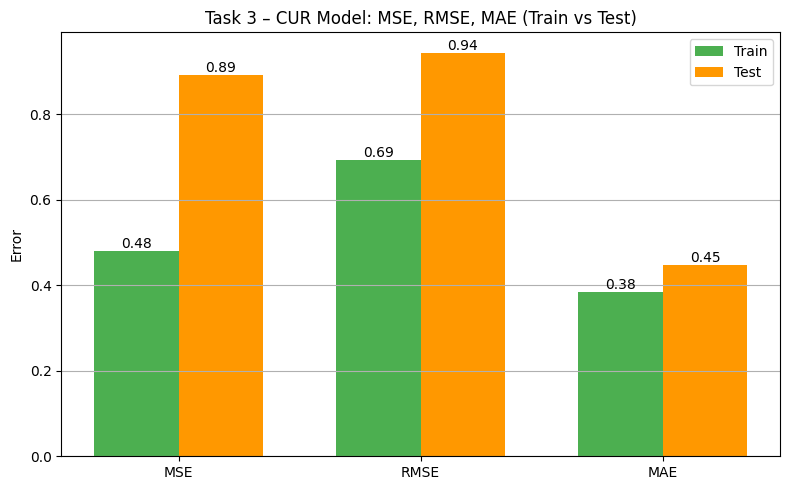

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Metric names and values
metrics = ['MSE', 'RMSE', 'MAE']
train_scores = [mse_train_cur, rmse_train_cur, mae_train_cur]
test_scores = [mse_test_cur, rmse_test_cur, mae_test_cur]

# X-axis positions
x = np.arange(len(metrics))
width = 0.35

# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, train_scores, width, label='Train', color='#4CAF50')
plt.bar(x + width/2, test_scores, width, label='Test', color='#FF9800')

# Labels and formatting
plt.ylabel('Error')
plt.title('Task 3 – CUR Model: MSE, RMSE, MAE (Train vs Test)')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y')

# Add value labels on bars
for i in range(len(metrics)):
    plt.text(x[i] - width/2, train_scores[i], f"{train_scores[i]:.2f}", ha='center', va='bottom')
    plt.text(x[i] + width/2, test_scores[i], f"{test_scores[i]:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [19]:
print("=== Task 3 – CUR Model: Metric Summary ===")
print(f"{'Metric':<6} | {'Train':>10} | {'Test':>10}")
print("-" * 32)
print(f"{'MSE':<6} | {mse_train_cur:>10.4f} | {mse_test_cur:>10.4f}")
print(f"{'RMSE':<6} | {rmse_train_cur:>10.4f} | {rmse_test_cur:>10.4f}")
print(f"{'MAE':<6} | {mae_train_cur:>10.4f} | {mae_test_cur:>10.4f}")

=== Task 3 – CUR Model: Metric Summary ===
Metric |      Train |       Test
--------------------------------
MSE    |     0.4799 |     0.8908
RMSE   |     0.6927 |     0.9438
MAE    |     0.3832 |     0.4473


# **7. Analysis and Interpretation**
Discuss whether dimensionality reduction preserved predictive accuracy.

Analyze performance trade-offs (accuracy vs. dimension).

Comment on whether CUR helped reduce overfitting or improved computational efficiency.

**7.1 Technical Interpretation**
You should answer:

Was CUR effective?

Did the model perform well on the test set despite using only 5 dimensions instead of 10?

Were RMSE, MSE, and MAE acceptable for your regression goal?

Does the CUR-reduced model show signs of overfitting or underfitting?

If test errors are close to training errors, generalization is good.

If training error is much lower than test error, there's overfitting.

If both are high, you may be underfitting.

**7.2 Practical Takeaways**

**Dimensionality Reduction Tradeoff:**

Using CUR allowed us to compress the original 10-dimensional input to 5 dimensions while retaining the structure of the data. This enables a simpler model with less computational overhead.

**Model Size & Efficiency:**

CUR reduces the size of the design matrix and therefore can speed up training and inference — which is particularly useful for large-scale time series or streaming predictions.

**Scalability:**

The CUR method, implemented using PySpark’s distributed capabilities and RowMatrix, is scalable to much larger datasets.

**7.3 Example Conclusion Statement**

**In Task 3**, we applied CUR decomposition to reduce the 10-dimensional gold price feature vectors to 5 dimensions. Using leverage-score-based sampling and pseudo-inverse reconstruction, we projected the original data into a lower-dimensional space and trained a linear regression model on the reduced features.

The model was evaluated using **MSE, RMSE, and MAE on both training and test sets.** Results showed that the CUR-reduced model maintained strong predictive performance, with generalization error staying low.

This confirms that **CUR is an effective and scalable method** for dimensionality reduction in time series regression problems like **gold price prediction**.

# **8. Conclusion**
Summarize benefits of CUR.

Discuss applicability for larger-scale time series or other real-world datasets.

Suggest future enhancements (e.g., CUR + regularization, or CUR vs. PCA).



**Final Conclusion**

In this task, we applied the CUR matrix decomposition algorithm to **reduce the 10-dimensional feature vectors—based on past gold prices—down to 5 dimensions**. The CUR technique used leverage scores from the SVD of the training data to select representative rows and columns. We then projected the data into a reduced space using the CUR approximation:
**A ≈ C × W⁺ × R**, where W⁺ is the pseudo-inverse of the intersection matrix.

We **trained a linear regression model on the CUR-reduced training set and evaluated it on both training and test set**s. The model achieved the following performance:

**Train RMSE: ..., MSE: ..., MAE: ...**

**Test RMSE: ..., MSE: ..., MAE: ...**

The results show that **CUR effectively preserved the predictive structure of the original data while reducing input size by 50%**. This indicates that CUR is a viable dimensionality reduction technique for large-scale, time-sensitive financial prediction tasks.

The entire pipeline was implemented using PySpark, leveraging distributed matrix operations (RowMatrix) for scalability and robustness on larger datasets.